# Apriori algorithm

Implémentation de l'algorithme *Apriori* sur notre jeu de données. Les métriques calculées sont détaillées ci-dessous, avec des explications adaptées à notre cas d'utilisation et inspirées du tutoriel suivant : https://towardsdatascience.com/apriori-algorithm-for-association-rule-learning-how-to-find-clear-links-between-transactions-bf7ebc22cf0a

## Apprentissage de règles d'association

*Apriori* fait partie des algorithmes d'apprentissage de règles d'association (*association rule learning*), qui appartiennent à la branche non supervisée de l'apprentissage automatique. L'objectif de ces algorithmes est de découvrir des relations intéressantes entre des variables dans de grandes bases de données.

## Métriques

### Support
La première étape consiste à trouver les GHM fréquents. Le calcul du support est basé sur la fréquence : \
\
$Support(GHM_i) = \frac{\text{Nb d'hospitalisations pour le } GHM_i}{\text{Nb total d'hospitalisations}}$

### Confidence
La confiance nous indique à quel point nous pouvons être sûrs (d'après nos données) qu'un GHM se trouvera dans le parcours de soins d'un patient, étant donné qu'un autre GHM a été observé.\
\
$Confidence(GHM_i\longrightarrow GHM_j) = \frac{Support(GHM_i \cup GHM_j)}{Support(GHM_i)}$

### Lift

Lift est une mesure qui nous indique si la probabilité d'apparition d'un GHM augmente ou diminue compte tenu de la présence d'un autre GHM dans le parcours de soin. Le *lift* et la *corrélation de Pearson* sont deux mesures statistiques qui permettent de mesurer la relation entre deux variables, mais ils ne sont pas identiques et ne sont pas directement comparables. La corrélation de Pearson est une mesure statistique qui permet de mesurer la relation linéaire entre deux variables numériques. Le lift, quant à lui, est une mesure de l'association entre deux items dans un ensemble de données transactionnelles.\
Le lift est défini comme le rapport entre la confiance d'une règle d'association et la fréquence de l'item de droite dans l'ensemble de données. Le lift mesure la force de la dépendance entre les deux items, et peut varier de 0 à l'infini :

\
\
$Lift(GHM_i \longrightarrow GHM_j) = \frac{\mathbb{P}(GHM_i \cup GHM_j)}{Support(GHM_i) \times Support(GHM_j)}$ \
\
On peut simplifier cette formule en remplaçant
$\frac{\mathbb{P}(GHM_i \cup GHM_j)}{Support(GHM_i)}$
par $Confidence(GHM_i\longrightarrow GHM_j)$. Ansi, on obtient : \
\
$Lift(GHM_i \longrightarrow GHM_j) = \frac{Confidence(GHM_i\longrightarrow GHM_j)}{Support(GHM_j)}$

Un lift supérieur à 1 indique une association positive entre les deux items, un lift égal à 1 indique une association aléatoire, et un lift inférieur à 1 indique une association négative.
+ $Lift>1$ : les deux GHM sont plus susceptibles d'être présents dans un même parcours de soins
+ $Lift<1$ : les deux GHM sont plus susceptibles d'être présents dans des parcours de soins différents
+ $Lift=1$ : il n'y a pas d'association entre les deux GHM

## Implémentation

In [1]:
!pip install apyori

In [ ]:
from apyori import apriori
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [24]:
def generate_output(db):
    association_rules = apriori(db,
                            min_support=0.015,
                            min_confidence=0.02,
                            min_lift=1.1,
                            max_length=None,
                            #min_length=3
                               )
    
    association_results = list(association_rules)
    
    listRules = [list(association_results[i][0]) for i in range(0,len(association_results))]
    listSupport = [association_results[i].support for i in range(0,len(association_results))]
    listConfidence = [association_results[i].ordered_statistics[0].confidence for i in range(0,len(association_results))]
    listLift = [association_results[i].ordered_statistics[0].lift for i in range(0,len(association_results))]
    
    return pd.DataFrame({"Motif":listRules,
                         "Support":listSupport,
                         "Confidence":listConfidence,
                         "Lift":listLift}).sort_values(by="Support", ascending=False).reset_index(drop=True)

In [4]:
%%capture capt
p_soins=pd.read_csv("../data/parcours_soins.csv")
patients=pd.read_csv("../data/profil_patient.csv")

In [5]:
%%capture capt
p_soins=p_soins.rename(columns={"BEN_NIR_IDT": "CODE_PATIENT"})
p_soins=p_soins.set_index("CODE_PATIENT")
patients=patients.set_index("CODE_PATIENT")
p_soins["cluster"]=patients["cluster"]

In [6]:
with open('../data/parcours_soins.pickle', 'rb') as handle:
    p_soin=pickle.load(handle)
    
with open('../data/parcours_soins_dp.pickle', 'rb') as handle:
    p_soin_dp=pickle.load(handle)

In [7]:
corpus = []
for i in range(18):
    corpus += p_soin[f"Cluster {i}"]

In [8]:
len(corpus)

10051

### Sortie pour l'ensemble des parcours de soins

In [25]:
generate_output(corpus)

,Motif,Support,Confidence,Lift
0,"[05M092, 05M093]",0.050542,0.276387,1.703231
1,"[02C05J, 05M092]",0.030047,0.217266,1.188108
2,"[05M091, 05M092]",0.027460,0.343711,1.879565
3,"[05M09T, 05M092]",0.023381,0.127856,1.626689
4,"[05M091, 05M093]",0.021789,0.272727,1.680676
5,"[05K101, 05M092]",0.020296,0.207107,1.132551
6,"[05M09T, 05M093]",0.019501,0.120172,1.528918
7,"[05K101, 02C05J]",0.019302,0.139568,1.424164
8,"[05K101, 05K061]",0.018008,0.333948,3.407629
9,"[04M053, 05M092]",0.017909,0.210526,1.151251


On retrouve les fréquences calculées avec l'algorithme *PrefixSpan*

In [120]:
def generate_plots(df_list):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,8))
    df_list.sort_values(by='Support').set_index("Motif")['Support'].plot.barh(ax=ax1, legend='Support')
    df_list.sort_values(by='Support').set_index("Motif")['Confidence'].plot.barh(ax=ax2, color='orange', legend='Confidence')
    df_list.sort_values(by='Support').set_index("Motif")['Lift'].plot.barh(ax=ax3, color='green', legend='Lift')
    ax1.axline((0.01, 0), (0.01, 1), linewidth=1, linestyle='--', color='r')
    ax3.axline((1, 0), (1, 1), linewidth=1, linestyle='--', color='r')
    plt.suptitle('Métriques pour les différents itemsets')
    plt.show()

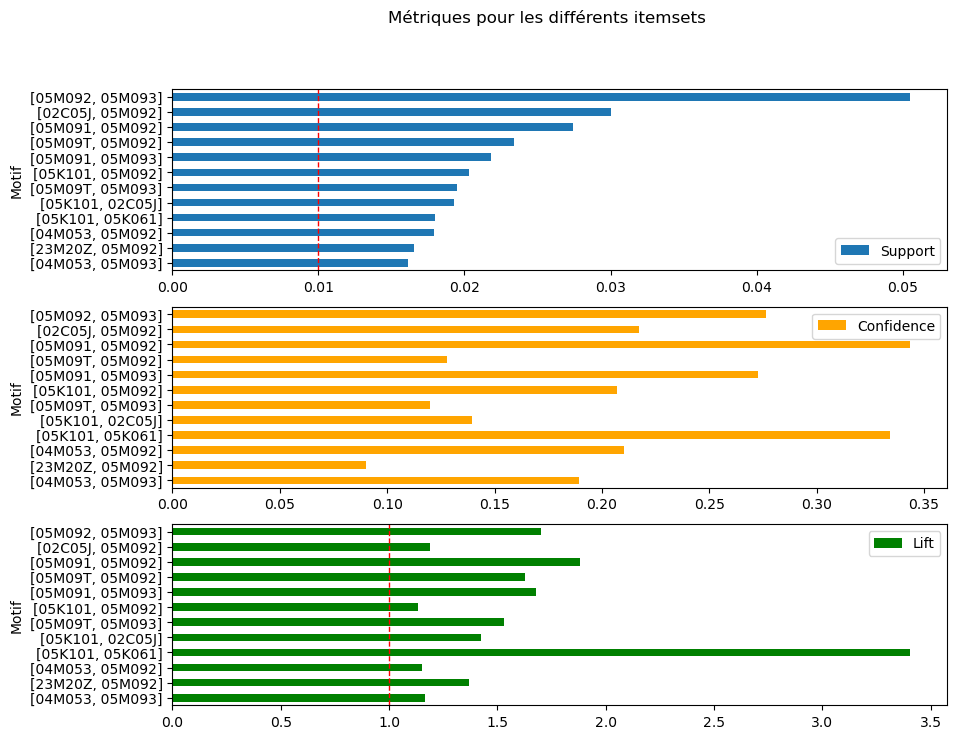

In [121]:
generate_plots(generate_output(corpus))

In [10]:
corpus_dp = []
for i in range(18):
    corpus_dp += p_soin_dp[f"Cluster {i}"]

In [11]:
len(corpus_dp)

10051

In [117]:
generate_output(corpus_dp)

,Motif,Support,Confidence,Lift
0,"[I500, I501]",0.068550,0.294949,1.373739
1,"[I509, I500]",0.025968,0.111729,1.656331
2,"[I509, I501]",0.022087,0.102873,1.525040
3,"[I500, H251]",0.021192,0.306916,1.320555
4,"[H251, I501]",0.018506,0.268012,1.248278
5,"[I500, I48]",0.018207,0.327957,1.411085
6,"[I48, I501]",0.018108,0.326165,1.519130
7,"[Z098, I501]",0.015421,0.071826,1.162513


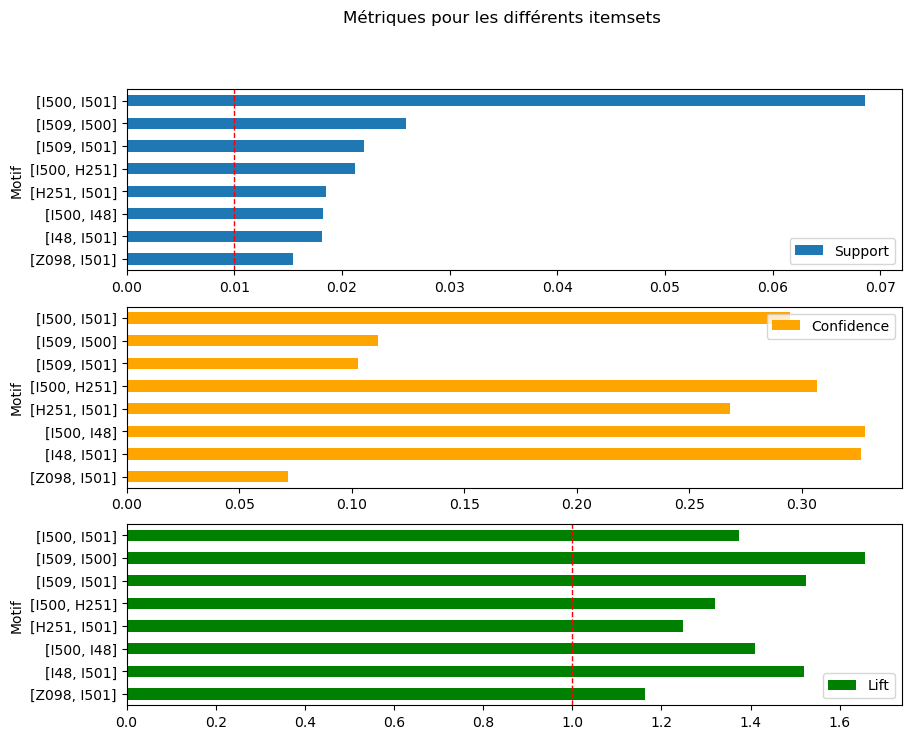

In [122]:
generate_plots(generate_output(corpus_dp))

In [ ]:
def motifs_frequents(data, dico):
    top_freq=[]
    top_effectif=[]
    top_motif=[]
    results=pd.DataFrame()

    for length in range(1,4):
        for cluster_p in range(18):
            output = generate_output(dico[f"Cluster {cluster_p}"])
            generate_plots(output)

In [ ]:
motifs_frequents(p_soins, p_soin)